In [1]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#from rembg import remove

from config import *
from cropping import *
from landmarks_utils import *
from preprocessing import *
from face_landmarking_model import *
from face_dataset import *

In [4]:
model = FaceLandmarking().to(DEVICE)
face_dataset = FaceDataset(model)
face_dataloader = DataLoader(face_dataset, batch_size=50, shuffle=True)
optimizer1 = torch.optim.Adam(model.raw_projection.parameters(), lr = 0.0001)
optimizer2 = torch.optim.Adam(model.cnn_focusing.parameters(), lr = 0.0001)
optimizer3 = torch.optim.Adam(model.ffn.parameters(), lr = 0.0001)

In [5]:
epochs = 1000
PRETRAINING = True
pretrain_epochs = 500
optimizers = [optimizer1]
TRAIN_PHASE = 0

for epoch in range(epochs):

    if epoch == pretrain_epochs:
        PRETRAINING = False
        optimizers = [optimizer2]
        TRAIN_PHASE += 1
        print('Freezing raw_projection, training CNN_focusing.')

    if epoch == 600:
        optimizers = [optimizer3]
        TRAIN_PHASE += 1
        print('Freezing CNN_focusing, training top FFN.')

    if epoch == 800:
        optimizers = [optimizer1, optimizer2, optimizer3]

    face_dataset.pretraining = PRETRAINING
    model.train_phase = TRAIN_PHASE

    for iteration, batch in enumerate(face_dataloader):
        for optimizer in optimizers:
            optimizer.zero_grad()

        inputs, targets, centroid, size_measure, multicrop = batch
        _, final_loss, raw_loss = model(
            inputs,
            targets = targets,
            centroid = centroid,
            size_measure = size_measure,
            multicrop = multicrop,
        )

        final_loss.backward()

        for optimizer in optimizers:
            optimizer.step()

        if iteration == 0:

            if epoch <= pretrain_epochs and epoch % 50 == 0:
                print(f'Epoch: {epoch}, current loss: {final_loss}.')

            if epoch > pretrain_epochs and epoch % 2 == 0:
                print(f'Epoch: {epoch}, iteration: {iteration}, final loss: {final_loss}, raw loss: {raw_loss}.')

Epoch: 0, current loss: 0.3203639090061188.
Epoch: 50, current loss: 0.004557771608233452.
Epoch: 100, current loss: 0.004555544350296259.
Epoch: 150, current loss: 0.005858145654201508.
Epoch: 200, current loss: 0.0043980712071061134.
Epoch: 250, current loss: 0.003389147110283375.
Epoch: 300, current loss: 0.004108121618628502.
Epoch: 350, current loss: 0.004238814115524292.


KeyboardInterrupt: 

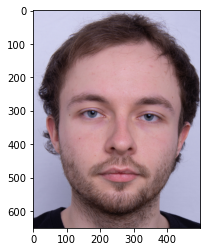

In [86]:
group = sample_groups[np.random.randint(len(sample_groups))]
for file in os.listdir(group):
    if '.TPS' in file or '.tps' in file:
        tps = readtps(group + '/' + file, group)
        
idx = np.random.randint(len(tps['im']))
true_l= tps['coords'][:, :, idx]
img_path = group + '/' + tps['im'][idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
subimage, xmin, ymin, xmax, ymax = crop_face_only(image)
subimage = standard_face_size(subimage)
plt.imshow(subimage)

In [73]:
@torch.no_grad()
def show_some_results(group = None, idx = None):
    if group is None:
        group = sample_groups[np.random.randint(len(sample_groups))]
    
    for file in os.listdir(group):
        if '.TPS' in file or '.tps' in file:
             tps = readtps(group + '/' + file, group)
        
    if idx is None:
        idx = np.random.randint(len(tps['im']))
        
    true_landmarks = tps['coords'][:, :, idx]
    img_path = group + '/' + tps['im'][idx]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    face_detail = crop_face_only(image)
    if face_detail:
        subimage, xmin, ymin, xmax, ymax = face_detail
    
    # Both model use float(0,1) for x and y axis
    input_landmarks = MediaPipe_model(subimage)
    #input_landmarks = np.concatenate((LBF_model(image), MediaPipe_model(image)), axis = 0)

    #true_landmarks = np.subtract(true_landmarks, (xmin, image.shape[0] - ymax))
    #true_landmarks = np.divide(true_landmarks, (subimage.shape[1], subimage.shape[0]))
     
    # Převod původních pixelových na float, flip y-axis
    true_landmarks = torch.from_numpy(1 - np.divide(true_landmarks, (image.shape[1], image.shape[0]))).to(device)

    # batch_dim = 0
    input_landmarks = torch.from_numpy(input_landmarks.reshape(1,-1)).float().to(device)
    raw_landmarks, _ = model.raw_projection(input_landmarks, None)

    multicrop = make_landmark_crops(raw_landmarks, subimage)
    
    #předělat a použít prediction method
    projection, _, _ = model(input_landmarks, true_landmarks.reshape(1,-1), multicrop = multicrop[None,:,:,:], image_shape = subimage.shape)
    projection = projection.cpu().detach().numpy().reshape(true_landmarks.shape)
    
    # tady připočíst xmin a ten druhý pól image_shape - ymax
    return projection, image, true_landmarks, raw_landmarks

In [ ]:
model.eval()
idx = -1

In [ ]:
idx += 10

In [ ]:
proj, im, y, raw = show_some_results(idx)

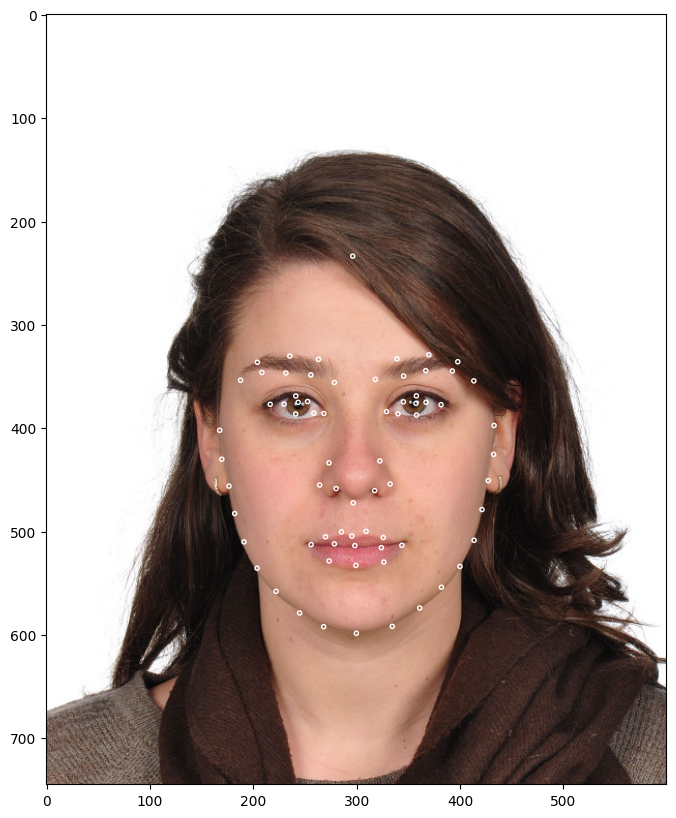

In [ ]:
display_landmarks(proj.reshape(-1,2), im, pixel_scale = False, origin = 'upper_left')